# DIP Monsoon 2021 Project
# Reflection Removal by Ghost Effect from A Single Image

### Team Photo

### Team Members -
- Eshan Gupta (2019102044)
- Saravanan Senthil (2019101016)
- Ashuthosh Bharadwaj (2019112003)
- Aniketh Reddimi (2018102014)


In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

# Draft of the algorithm and brainstorming
## Step 1: _Shift Amount Determination_
-  We have an image `im`
-  It has a reflection caused by a glass surface
-  We take canny edge of the image and look for a shifted match

    <img src="../documents/imgs/Reflection.jpeg" width= "350" height= "325">

What does this mean? Once we get the edges, the reflection follows a ghost effect (two reflections are produced because of the glass) This would mean that a template matching algorithm (like a hit/miss) would give a maximum at the shifted postion. Using this we can determine factor `d` which is the shift. There is definitely going to be some attenuation, i.e., the second reflection will have lower intensity than the first, because the glass absorbs more energy from the light that eventually creates the second reflection (notice that the ray spends longer inside the glass).

### Why edges?
In theory, we have modelled the image as a vector addition of 3 terms, the scene image, the first reflection and the shifted reflection. This isn't be directly separable in the image domain because we don't know which pixel is assigned to the scene image and which one goes to the reflections. In the edge-domain, there is not much overlap between the scene edges and the reflection edges. 

## Step 2: _Gradient Separation_
Now that we have info on the shift, we can proceed with separating the Gradient.
### How?
We have the information pertaining to the expected shift, which means, everytime we come across a gradient, if we check $arg + \vec{d}$ and $arg - \vec{d}$ and if they correspond to maxima too, then we assign that particular pixel to the reflection image.

More details on this when we implement.

## Step 3: _Image Reconstruction_
Function = Edge = thresholded dervivative
*Step 1* : Find which kernel f(x,y) will act as the thresholded derivative when convolved with an image, ie: f(x,y) * image = edge image (figure out for canny, or we will roll with simple derivative operator and scrap canny)

*Step 2* : perform the following:
f1 = f(-x,-y) 
h = fft( f1 * f)
g = ifft( ones(image shape) / h)
Output = g*f1*(edge image)


-----------------------------------------------------------------------------------

In [2]:
from tqdm import tqdm
def do_template_matching(im,kernel):
    return cv2.matchTemplate(im,kernel,cv2.TM_CCOEFF)


def takeTemplatematch(edges, img,d,thresh, k=30, maxVal=255):
    M, N = edges.shape
    ret = np.zeros_like(edges)
    where = np.array(np.where(edges == 255)).T
    where = [i for i in where if i[0] < M-k-d[0] and i[1] < N-k-d[1] and i[0] > d[0]+ 5 and i[1] >d[1] + 5]

    for i, j in tqdm(where):
        temp = img[i:i+k,j:j+k]
        t = do_template_matching(img,temp)
        # how to modify __ because shapes are different. To be ironed out.
        # if (t[i - d[0],j - d[1]] >= thresh or t[i + d[0],j + d[1]] >= thresh):
        if t[i-d[0], j-d[1]] >= np.max(t[i-d[0]-5:i-d[0]+5,j-d[1]-5:j-d[1]+5]) / 1.5:
            ret[i, j] = 1
        if t[i+d[0], j+d[1]] >= np.max(t[i+d[0]-5:i+d[0]+5,j+d[1]-5:j+d[1]+5]) / 1.5:
            ret[i, j] = 1
    return ret*maxVal


In [3]:
def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image) * 0.5
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
	# return the edged image
	return edged

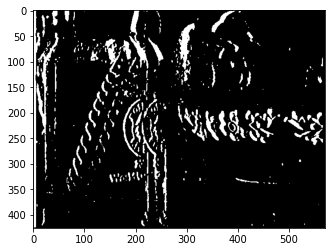

In [3]:
img = cv2.imread('./img.png', 0)
# c2 = cv2.Canny(img,43,53)
c2 = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=7)
c2 = c2[..., ::-1]
c2 = c2 > 3000
imgRev = img[..., ::-1]
c2 = c2 * 255
# c2 = auto_canny(imgRev, 0)
plt.imshow(c2, cmap='gray')

In [4]:
r = takeTemplatematch(c2,imgRev, np.array([0, 35]), 30000)


100%|██████████| 16456/16456 [00:58<00:00, 280.22it/s]


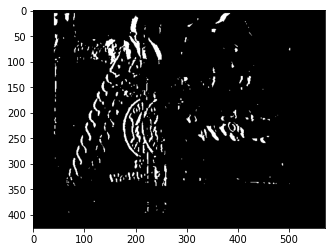

In [5]:
plt.imshow(r, cmap='gray')

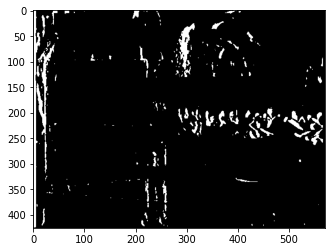

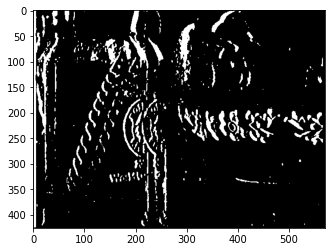

In [6]:

# plt.imshow(np.prod(r.astype(int), c2.astype(int)))
plt.imshow(c2 - (r), cmap='gray')
plt.show()
plt.imshow(c2, cmap='gray')
plt.show()

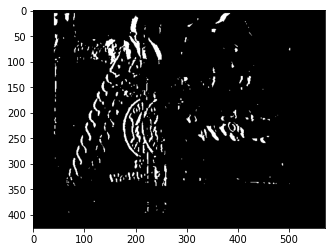

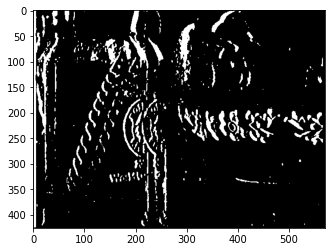

In [7]:
rr = r.copy()
# rr[:, 250:] = 0
plt.imshow(rr, cmap='gray')
plt.show()
plt.imshow(c2, cmap='gray')
plt.show()

In [77]:
from utils import fillHoles

closing = cv2.morphologyEx(rr, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20)))

closing = fillHoles(closing//255, 1000)
print('a', np.max(closing))
plt.imshow(closing, cmap='gray')

error: OpenCV(4.5.3) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-xxsyexfp/opencv/modules/imgproc/src/morph.simd.hpp:841: error: (-213:The function/feature is not implemented) Unsupported data type (=4) in function 'getMorphologyFilter'


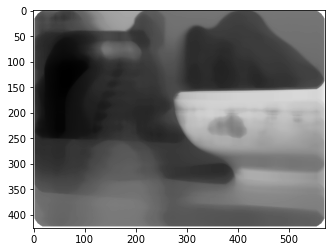

In [42]:
medianIMG = cv2.medianBlur(img[..., ::-1], 31)

plt.imshow(medianIMG, cmap='gray')

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False,  True],
       [ True,  True,  True, ..., False, False,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

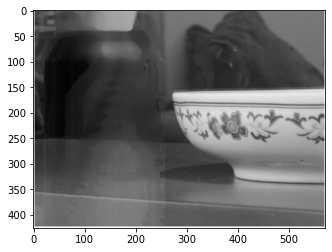

In [34]:
ret = img.copy()[..., ::-1]


for i in range(ret.shape[0]):
    for j in range(ret.shape[1]):
        if (closing[i, j]):
            ret[i, j] = medianIMG[i, j]
plt.imshow(ret, cmap='gray')
ret == medianIMG

In [12]:
# plt.imshow(np.logical_or(closing*255, c2), cmap='gray')

In [13]:
# plt.imshow( np.log(1 + np.abs(np.fft.fftshift(np.fft.fft2(img)))), cmap='gray')
# print(img.shape)
# x = np.fft.fftshift(np.fft.fft2(img))
# x[218:, 292:] = 255 +255j
# x[:208, :284] = 255 +255j
# plt.imshow(np.log(1 + np.abs(x)))
# plt.subplot(1,2,1)
# plt.imshow(np.abs(np.fft.ifft2(np.fft.ifftshift(x))), cmap='gray')

# plt.subplot(1,2,2)
# plt.imshow(img, cmap='gray')

In [14]:
# from utils import getHistogram
# print(np.sum(rr == 0))
# print(np.sum(rr == 255))
# rr1 = rr==255
# np.prod(rr.shape)
# plt.imshow(rr1, cmap='gray')
# plt.imsave('edges.png', rr1)

In [8]:
import scipy
from scipy import signal

In [16]:
#c2fft = np.fft.fft2(c2)
#imgfft = np.fft.fft2(img)
#f = np.fft.ifft2(imgfft/c2fft)
#f1 = f[::-1,::-1]
#h = np.fft.fft2(signal.convolve2d(f1,f))
#g = np.fft.ifft2(np.ones((img.shape[0],img.shape[1]))/h)
#out = signal.convolve2d(g,signal.convolve2d(f1,c2))





In [17]:
#plt.imshow(out,cmap='gray')

In [18]:
c2fft = np.fft.fft2(c2)
imgfft = np.fft.fft2(img)
f = np.fft.ifft2(imgfft/c2fft)
f1 = f[::-1,::-1]
h = np.fft.fft2(np.fft.ifft2(np.fft.fft2(f1)*np.fft.fft2(f)))
g = np.fft.ifft2(np.ones(img.shape)/h)
out = np.fft.ifft2(np.fft.fft2(f1)*np.fft.fft2(g)*np.fft.fft2(c2))



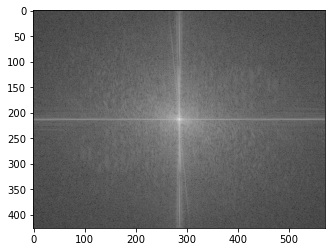

In [19]:
plt.imshow(np.log(1+np.abs(np.fft.fftshift(imgfft))),cmap='gray')

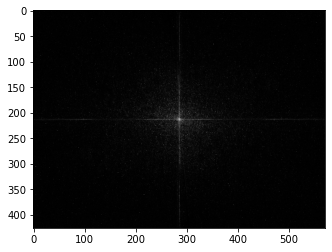

In [20]:
plt.imshow(np.log(1+np.abs(np.fft.fftshift(imgfft*0.00001 + 0.99*imgfft/(c2fft[...,::-1])))),cmap='gray')

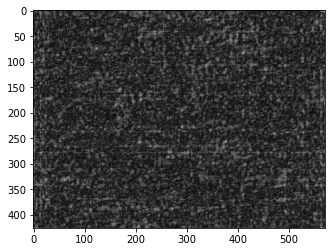

In [21]:
plt.imshow(np.abs(np.fft.ifft2(imgfft/(c2fft[...,::-1]))),cmap='gray')

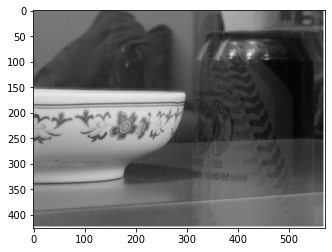

In [22]:
plt.imshow(img, cmap='gray')

In [9]:
c2 = c2 - rr
c2fft = np.fft.fft2(c2)
imgfft = np.fft.fft2(img)
f = np.fft.ifft2(imgfft/c2fft)
f1 = f[::-1,::-1]
h = np.fft.fft2(np.fft.ifft2(np.fft.fft2(f1)*np.fft.fft2(f)))
g = np.fft.ifft2(np.ones(img.shape)/h)
out = np.fft.ifft2(np.fft.fft2(f1)*np.fft.fft2(g)*np.fft.fft2(c2))



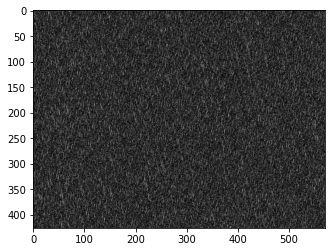

In [10]:
plt.imshow(np.abs(out),cmap='gray')